# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1689051192.zip, parmi :

data_BEN_1688637099.zip
data_BEN_1688102709.zip
data_BEN_1688537340.zip
data_BEN_1688797047.zip
data_BEN_1688275008.zip
data_BEN_1688365899.zip
data_BEN_1688701686.zip
data_BEN_1689051192.zip
data_BEN_1688193619.zip
data_BEN_1688968952.zip
data_BEN_1688879928.zip


In [4]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-07-11.zip, parmi 

File-Export-2020-08-03-to-2023-07-01.zip
File-Export-2020-08-03-to-2023-07-02.zip
File-Export-2020-08-03-to-2023-07-03.zip
File-Export-2020-08-03-to-2023-07-08.zip
File-Export-2020-08-03-to-2023-07-11.zip
File-Export-2020-08-03-to-2023-06-30.zip
File-Export-2020-08-03-to-2023-07-09.zip
File-Export-2020-08-03-to-2023-07-07.zip
File-Export-2020-08-03-to-2023-07-10.zip
File-Export-2020-08-03-to-2023-07-05.zip
File-Export-2020-08-03-to-2023-07-06.zip


In [5]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_ecf6de13-f25d-4214-a320-c5031b681d7c.zip, parmi :

polar-user-data-export_ecf6de13-f25d-4214-a320-c5031b681d7c.zip


In [6]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight_imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-07-11.zip, data_BEN_1689051192.zip, polar-user-data-export_ecf6de13-f25d-4214-a320-c5031b681d7c.zip


In [7]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])

df_weight.sort_index(inplace=True)

In [8]:
# forward propagate actual values into NaN
df_weight.fillna(method="ffill", inplace=True)

In [9]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-06-27,72.473750,9.835000,3.172500,59.448750,43.600000,0.135704,1722.997000
2023-06-28,72.095000,11.170000,3.052500,57.858750,41.221250,0.154934,1685.980000
2023-06-29,71.606000,11.876000,2.988000,56.726000,39.886000,0.165852,1660.168000
2023-06-30,72.206667,11.803333,3.021667,57.366667,40.545000,0.163466,1674.712000
2023-07-01,72.196000,12.130000,3.002000,57.048000,40.162000,0.168015,1667.425600
2023-07-02,71.887143,11.975714,2.994286,56.902857,40.045714,0.166590,1664.086857
2023-07-03,71.750000,11.575714,3.011429,57.147143,40.374286,0.161334,1669.764571
2023-07-04,72.358000,11.880000,3.026000,57.434000,40.600000,0.164184,1676.324800
2023-07-05,72.065714,11.398571,3.037143,57.611429,40.897143,0.158169,1680.410286


In [10]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-06-27,72.933244,10.645704,3.142658,59.128146,42.922139,0.146002,1715.410869
2023-06-28,72.696672,10.935275,3.103872,58.641253,42.189889,0.150425,1704.046184
2023-06-29,72.416305,11.038377,3.082974,58.279253,41.785849,0.152459,1695.763245
2023-06-30,72.312563,11.213751,3.066069,58.017552,41.448604,0.155096,1689.734347
2023-07-01,72.259135,11.293139,3.059008,57.891960,41.303583,0.156313,1686.865514
2023-07-02,72.151901,11.329828,3.051207,57.755861,41.158209,0.157064,1683.756780
2023-07-03,72.030651,11.480823,3.034626,57.499738,40.833464,0.159414,1677.876290
2023-07-04,72.014116,11.772966,3.013697,57.211917,40.404893,0.163482,1671.208833
2023-07-05,72.009932,11.805619,3.011503,57.176585,40.358592,0.163944,1670.413159


In [11]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

In [12]:
# df_food.tail(15)

In [13]:
# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum(numeric_only=True)

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [14]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-06-26,1632.8,39.5,129.9,173.6
2023-06-27,1759.6,40.4,159.9,189.5
2023-06-28,1767.4,62.0,99.9,203.6
2023-06-29,2323.4,78.0,260.5,139.9
2023-06-30,1644.9,13.5,206.0,172.8
2023-07-01,1762.7,13.7,213.6,194.3
2023-07-02,1718.1,30.9,221.2,132.9
2023-07-03,1547.3,21.0,202.0,135.8
2023-07-04,1926.2,27.5,284.9,133.6


In [15]:
df_food.rolling(window=7).mean().tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-06-26,1712.685714,50.900000,140.285714,162.785714
2023-06-27,1708.457143,49.128571,138.414286,171.085714
2023-06-28,1710.085714,52.014286,129.385714,175.000000
2023-06-29,1803.500000,56.757143,147.571429,168.785714
2023-06-30,1794.985714,48.571429,154.757143,177.028571
2023-07-01,1796.314286,43.985714,166.228571,175.285714
2023-07-02,1801.271429,39.714286,184.428571,172.371429
2023-07-03,1789.057143,37.071429,194.728571,166.971429
2023-07-04,1812.857143,35.228571,212.585714,158.985714


In [16]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [17]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

  0%|          | 1/1439 [00:00<02:35,  9.27it/s]

100%|██████████| 1439/1439 [00:12<00:00, 117.73it/s]


In [18]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-06-16,1802.117,261.0
2023-06-17,3390.337,384.0
2023-06-18,2640.713,313.0
2023-06-19,3600.000,200.0
2023-06-20,900.000,70.0
2023-06-21,1605.983,279.0
2023-06-22,3540.594,381.0
2023-06-23,1751.212,280.0
2023-06-24,2820.716,375.0
2023-06-25,1380.712,235.0


In [19]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight_imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [20]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-07-01,301,1920
2023-07-02,398,3300
2023-07-03,298,2100
2023-07-04,340,6000
2023-07-05,180,3240
2023-07-06,100,1800
2023-07-07,0,0
2023-07-08,427,2520
2023-07-09,390,3540


In [21]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [22]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-06-26,1200.000,80.0
2023-06-27,1500.625,236.0
2023-06-28,3544.713,420.0
2023-06-29,1800.000,100.0
2023-06-30,2700.837,348.0
2023-07-01,1920.000,301.0
2023-07-02,3300.000,398.0
2023-07-03,2100.000,298.0
2023-07-04,6000.000,340.0
2023-07-05,3240.000,180.0


In [23]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-06-26,1885.602429,242.857143
2023-06-27,1971.406000,266.571429
2023-06-28,2248.367429,286.714286
2023-06-29,1999.711143,246.571429
2023-06-30,2135.371857,256.285714
2023-07-01,2006.698143,245.714286
2023-07-02,2280.882143,269.000000
2023-07-03,2409.453571,300.142857
2023-07-04,3052.221429,315.000000
2023-07-05,3008.691000,280.714286


In [24]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [25]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [26]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [27]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [28]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-06-26,72.598750,10.518750,3.127500,58.940000,42.647500,0.144889,1710.928000,1632.8,39.5,129.9,173.6,1200.000,80.0,56.237111,1767.165111,-134.365111
2023-06-27,72.473750,9.835000,3.172500,59.448750,43.600000,0.135704,1722.997000,1759.6,40.4,159.9,189.5,1500.625,236.0,206.074394,1929.071394,-169.471394
2023-06-28,72.095000,11.170000,3.052500,57.858750,41.221250,0.154934,1685.980000,1767.4,62.0,99.9,203.6,3544.713,420.0,350.829685,2036.809685,-269.409685
2023-06-29,71.606000,11.876000,2.988000,56.726000,39.886000,0.165852,1660.168000,2323.4,78.0,260.5,139.9,1800.000,100.0,65.413167,1725.581167,597.818833
2023-06-30,72.206667,11.803333,3.021667,57.366667,40.545000,0.163466,1674.712000,1644.9,13.5,206.0,172.8,2700.837,348.0,295.649026,1970.361026,-325.461026
2023-07-01,72.196000,12.130000,3.002000,57.048000,40.162000,0.168015,1667.425600,1762.7,13.7,213.6,194.3,1920.000,301.0,263.946098,1931.371698,-168.671698
2023-07-02,71.887143,11.975714,2.994286,56.902857,40.045714,0.166590,1664.086857,1718.1,30.9,221.2,132.9,3300.000,398.0,334.441127,1998.527984,-280.427984
2023-07-03,71.750000,11.575714,3.011429,57.147143,40.374286,0.161334,1669.764571,1547.3,21.0,202.0,135.8,2100.000,298.0,257.415444,1927.180016,-379.880016
2023-07-04,72.358000,11.880000,3.026000,57.434000,40.600000,0.164184,1676.324800,1926.2,27.5,284.9,133.6,6000.000,340.0,223.588556,1899.913356,26.286644
2023-07-05,72.065714,11.398571,3.037143,57.611429,40.897143,0.158169,1680.410286,1758.0,69.9,188.4,86.5,3240.000,180.0,116.984614,1797.394900,-39.394900


In [29]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-06-26,72.901279,10.819275,3.122618,58.857848,42.522298,0.148464,1710.971298,1712.685714,50.900000,140.285714,162.785714,1885.602429,242.857143,205.507846,1916.479144,-203.793430
2023-06-27,72.933244,10.645704,3.142658,59.128146,42.922139,0.146002,1715.410869,1708.457143,49.128571,138.414286,171.085714,1971.406000,266.571429,227.464784,1942.875653,-234.418510
2023-06-28,72.696672,10.935275,3.103872,58.641253,42.189889,0.150425,1704.046184,1710.085714,52.014286,129.385714,175.000000,2248.367429,286.714286,242.414355,1946.460538,-236.374824
2023-06-29,72.416305,11.038377,3.082974,58.279253,41.785849,0.152459,1695.763245,1803.500000,56.757143,147.571429,168.785714,1999.711143,246.571429,207.388832,1903.152077,-99.652077
2023-06-30,72.312563,11.213751,3.066069,58.017552,41.448604,0.155096,1689.734347,1794.985714,48.571429,154.757143,177.028571,2135.371857,256.285714,214.595771,1904.330118,-109.344404
2023-07-01,72.259135,11.293139,3.059008,57.891960,41.303583,0.156313,1686.865514,1796.314286,43.985714,166.228571,175.285714,2006.698143,245.714286,206.601264,1893.466778,-97.152493
2023-07-02,72.151901,11.329828,3.051207,57.755861,41.158209,0.157064,1683.756780,1801.271429,39.714286,184.428571,172.371429,2280.882143,269.000000,224.655801,1908.412581,-107.141152
2023-07-03,72.030651,11.480823,3.034626,57.499738,40.833464,0.159414,1677.876290,1789.057143,37.071429,194.728571,166.971429,2409.453571,300.142857,253.395563,1931.271853,-142.214710
2023-07-04,72.014116,11.772966,3.013697,57.211917,40.404893,0.163482,1671.208833,1812.857143,35.228571,212.585714,158.985714,3052.221429,315.000000,255.897586,1927.106419,-114.249276
2023-07-05,72.009932,11.805619,3.011503,57.176585,40.358592,0.163944,1670.413159,1811.514286,36.357143,225.228571,142.257143,3008.691000,280.714286,222.491147,1892.904307,-81.390021


# Graphes

In [30]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

dict_hlines = {
        'Calories' : [ (1600, 'green'), (1700, 'orange'), (1800, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.14, 'green'), (.15, 'orange'), (.16,'red') ]
    }

In [31]:
def plot_general(longueur=15,
                 year=2023,
                 month=3,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

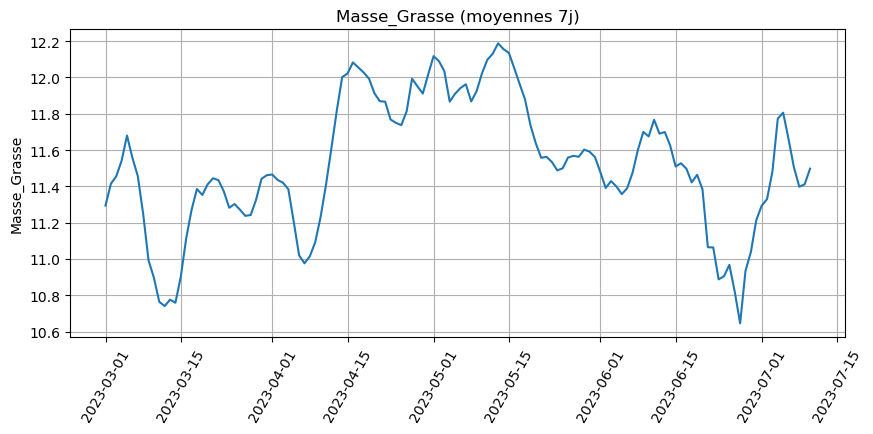

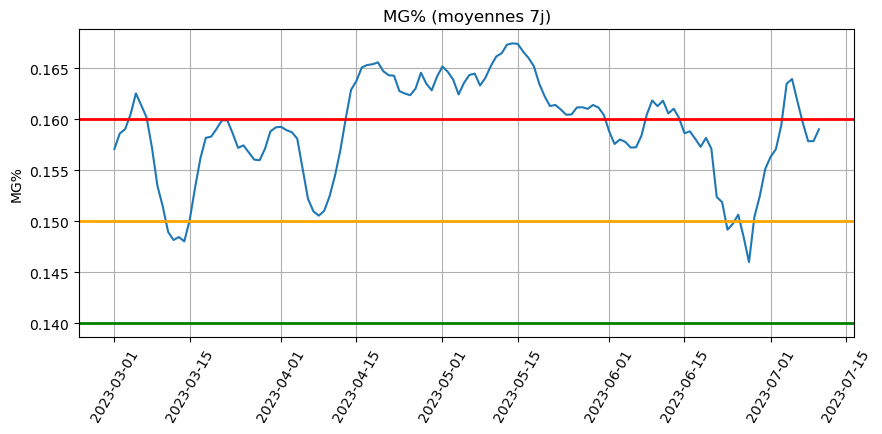

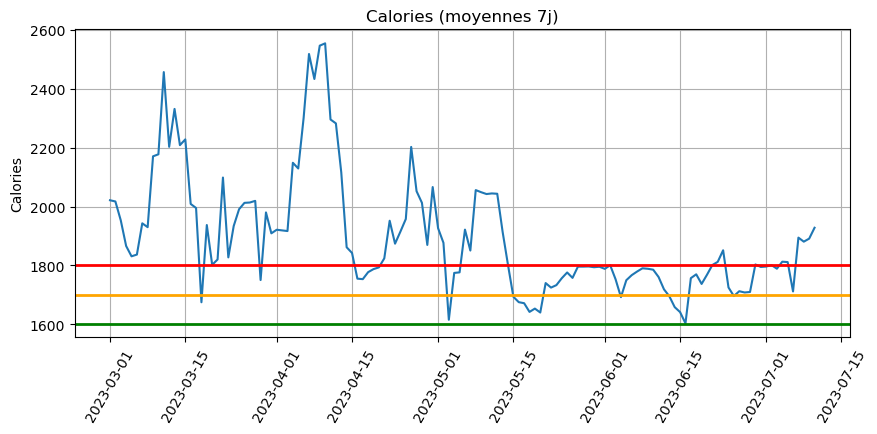

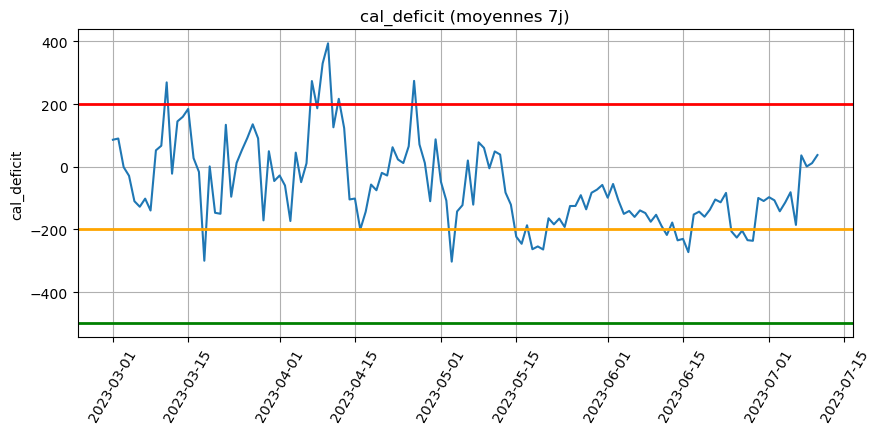

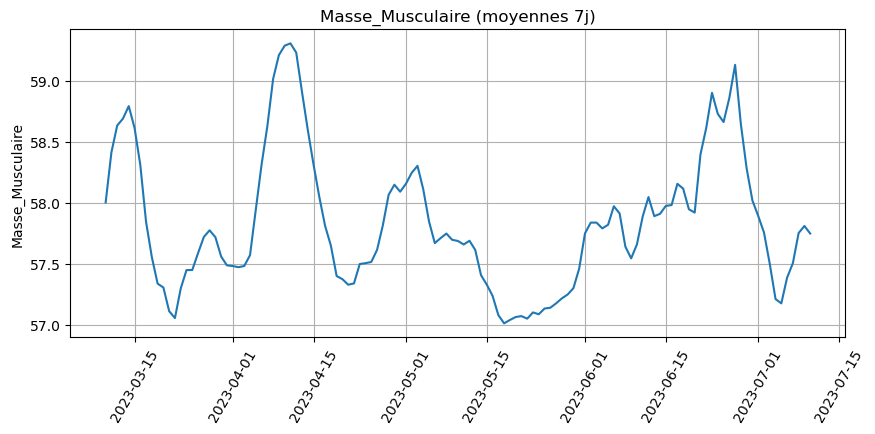

In [32]:
plot_general(longueur=7)

In [33]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=3, day=1)>

In [34]:
def plot_general2(longueur=15,
                 year=2023,
                 month=3,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.11, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [35]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general2(longueur=15, year=2023, month=3, day=1)>

In [36]:
def plot_general3(longueur=15,
                 year=2023,
                 month=3,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.11, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1500.0, top=2500.0)
    # ax2.legend()

In [37]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general3(longueur=15, year=2023, month=3, day=1)>